In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.cluster import OPTICS, Birch
import numpy as np

import re
from seaborn import heatmap

from nltk.corpus import stopwords

<h1>Course Recommendation System</h1>

Data provided by Concordia Open Data, files used last updated May 30 2023

catalog is the dataset that contains the course description <br>
sr is the default dataset that we will join on to obtain the final "dataset"

In [2]:
# Use Sniffer to infer the delimiter of the CSV file
with open('CATALOG.csv', 'r') as file:
    dialect = csv.Sniffer().sniff(file.read(1024))
    delimiter = dialect.delimiter

# Read the CSV file using pandas with the inferred delimiter
catalog = pd.read_csv('CATALOG.csv', delimiter=delimiter)
catalog = catalog.drop([ "Website",'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'], axis=1)
# Access the column containing potential commas

In [3]:
sr = pd.read_csv("CU_SR_OPEN_DATA_CATALOG.csv", encoding="utf_16_le")
sr = sr.drop(["Career"], axis=1)
# comb = pd.read_csv("CU_SR_OPEN_DATA_COMB_SECTIONS.csv", encoding="utf_16_le")

In [4]:
# catalog.columns
catalog["Subject_Catalog"] = catalog["Course code"] +"_"+ catalog["Course number"]

In [5]:
# sr.columns
sr["Subject_Catalog"] = sr["Subject"] +"_"+ sr["Catalog"]

In [6]:
dataset = sr.merge(catalog, on="Subject_Catalog")
dataset = dataset.drop(["Course code", "Course number", "Component Code", "Key", "Course ID", "Title"], axis=1)
dataset = dataset.fillna("")

<h1>Creation of Catalog Catagories </h1>

(ex: 200-level)

In [7]:
# returned as str instead of int for the sake of concatenation
def fun1(x):
    x = re.findall(r'\d+',x)[0]
    if int(x)<1000:
        return str((int(x)//100)*100)
    elif int(x)>=1000:
        return str((int(x)//1000)*10000)

dataset['Level'] = dataset['Catalog'].map(lambda x:fun1(x))

<h2> Categorical Breakdown

In [8]:
dataset["Degree"].value_counts()
dataset["Pre Requisite Description"].value_counts()
dataset["Equivalent Courses"].value_counts()

                        1605
ELEC 372 = ENGR 372        6
COEN 312 = COEN 212        6
COEN 421 = SOEN 422        5
AHSC538 = AHSC536          4
                        ... 
DFTT 211 = DFTT 298C       1
DFTT 211=SCEN 214          1
DFTT 341=SCEN 344          1
DFTT 470=SCEN 470          1
TESL471 = TESL498A         1
Name: Equivalent Courses, Length: 234, dtype: int64

<h2>Removing Stop Words & Encoding


In [9]:
enStop = stopwords.words('english')
frStop = stopwords.words('french')
dataset['Description_without_stopwords'] = dataset['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (enStop) and word not in (frStop)]))

In [10]:
''' 
Changes:
"Catalog" removed; "Level" added 
"Subject_Catalog" removed; "Subject" added
'''

dataset["Encoding"] = dataset["Long Title"]+ " " + dataset["Equivalent Courses"] + " " + dataset["Faculty"] + " " + dataset["Department"] + " " + dataset["Subject"] +" "+ dataset["Catalog"] +" "+ dataset["Level"] + " " + dataset["Degree"] + " " + dataset["Description_without_stopwords"]

<h1>Encoding for similarity comparison

In [11]:
vectorizer = CountVectorizer()
# vectorizer.get_feature_names_out()
oneHotEncoding = vectorizer.fit_transform(dataset["Encoding"]).toarray()

In [12]:
# note courses that have equivalencies will share the Catalog value in the OHE (one hot encoding)
termsPerCourse = np.array(vectorizer.inverse_transform(oneHotEncoding))

# list of columns available in the one hot encoding
all_Terms = np.array(vectorizer.get_feature_names_out())

C:\Users\chanj\AppData\Local\Temp\ipykernel_19036\2774674523.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  termsPerCourse = np.array(vectorizer.inverse_transform(oneHotEncoding))


In [13]:
numberOfSubjects = len(dataset['Subject'].unique())
numberOfFaculties = len(dataset['Faculty'].unique())

balance = 0.8
weighting = int(balance*numberOfSubjects + (1-balance)*numberOfFaculties)

In [14]:
birch_Model = Birch(n_clusters=weighting).fit_predict(oneHotEncoding)
# optics_Model = OPTICS(min_samples=2).fit_predict(oneHotEncoding)
final = {"Title": dataset["Long Title"],"Subject": dataset["Subject"],"Catalog": dataset["Catalog"], "Group": birch_Model, "Keywords": termsPerCourse}
df = pd.DataFrame(data=final)

In [15]:
Course_EncodedTerms = pd.DataFrame(oneHotEncoding, columns=all_Terms, index=dataset["Subject_Catalog"])
Course_EncodedTerms.head(100)

,10,100,108,10hrs,12,120,13,15,16,1960s,...,youth,zoroastrianism,écrite,écriture,éditeur,édition,élaboration,ét,étude,études
Subject_Catalog,,,,,,,,,,,,,,,,,,,,,
ACCO_355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCO_400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCO_420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCO_425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCO_435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AHSC_384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AHSC_384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AHSC_422,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [16]:
arrayOfColumns = []
for i in oneHotEncoding:
    arrayOfColumns.append([i])

Course_OHE = pd.DataFrame(arrayOfColumns, columns=["Encoding Array"], index=dataset["Subject_Catalog"])
Course_OHE = Course_OHE.sort_index()


<h1>Final Dataset</h1>

A DataFrame that holds two columns. First is the {Subject_Catalog}, second is the One Hot Encoding Vector for that Course

In [17]:
# Add an additional column to both dataframes to identify the source
df1 = Course_OHE.assign(key=1)
df2 = Course_OHE.assign(key=1)

# Perform an inner merge on the 'key' column
cartesian_product = df1.reset_index().merge(df2.reset_index(), on='key')

# Drop the 'key' column if you don't need it in the result
cartesian_product = cartesian_product.drop('key', axis=1)

In [18]:
matrix = []
for i in Course_OHE["Encoding Array"]:
    matrix.append(i[0:])
matrix = np.array(list(matrix))

In [19]:
# cartesian_product.head(50)
labels = cartesian_product["Subject_Catalog_x"]
similarity_matrix = cosine_similarity(matrix)

In [20]:
finalDF = pd.DataFrame(similarity_matrix, index=dataset["Subject_Catalog"], columns = dataset["Subject_Catalog"])

<AxesSubplot:xlabel='Subject_Catalog', ylabel='Subject_Catalog'>

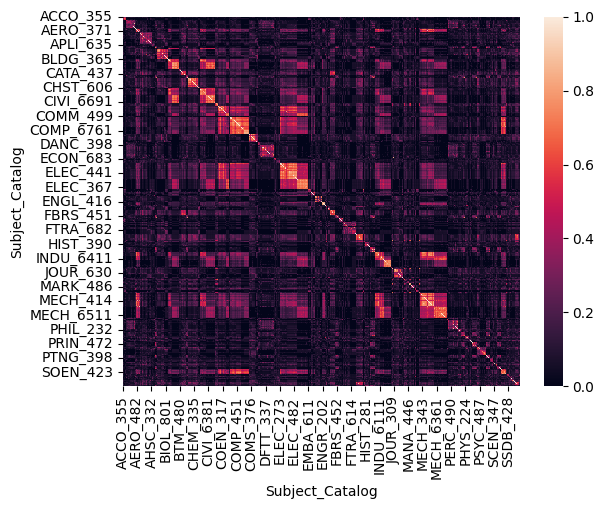

In [21]:
finalDF

heatmap(finalDF)

<h1>Set diagonal to -2 </h1>
This is done as the diagonal is the case where a course is compared to itself and therefore should always equal 1. Negative 2 was selected as this should be a value unachievable in a normal case.

In [22]:
finalDF.values[[np.arange(finalDF.shape[0])]*2] = -2

C:\Users\chanj\AppData\Local\Temp\ipykernel_19036\3490983325.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  finalDF.values[[np.arange(finalDF.shape[0])]*2] = -2


<h1>Find the top N similar courses for all courses</h1>

In [23]:
# Get the top 10 columns and their values for each row along with row name (index)
import warnings

# Disable all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


def findTopNMatches(number=5):
    top_N_values = pd.DataFrame(columns=['Row', 'Column', 'Value'])

    for idx, row in finalDF.iterrows():
        top_match = row.nlargest(number)
        top_N_values = top_N_values.append(
            [{'Row': idx, 'Column': col, 'Value': val} for col, val in top_match.iteritems()],
            ignore_index=True
        )
    return top_N_values

print(findTopNMatches())


           Row    Column     Value
0     ACCO_355  ACCO_425  0.436436
1     ACCO_355  ACCO_455  0.431124
2     ACCO_355  ACCO_653  0.377964
3     ACCO_355  ACCO_656  0.377964
4     ACCO_355  ACCO_400  0.347183
...        ...       ...       ...
9870  WSDB_494  WSDB_394  0.898146
9871  WSDB_494  SSDB_425  0.421776
9872  WSDB_494  WSDB_292  0.388057
9873  WSDB_494  SSDB_428  0.348155
9874  WSDB_494  SSDB_428  0.348155

[9875 rows x 3 columns]


<h1>Explanation of Choices and Possible Improvements</h1>
1) cannot remove the Course/Catalog number as it will be used to connect equivalent or dependent courses <br>
2) Possible use of stemming in both french and english to reduce the column space needed. This can be done after removing stop words or maybe before if the confidence is affected.